# TM10007 Assignment template

## Data loading and cleaning

Below are functions to load the dataset of your choice. After that, it is all up to you to create and evaluate a classification method. Beware, there may be missing values in these datasets. Good luck!

In [9]:
# import packages
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold

# Classifiers
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from worclipo.load_data import load_data

functions

In [10]:
# function to split the dataset into train and test
def split_set(X,y,test_size):

    if os.path.exists('./TEST_set.csv'):
        split_action = print('TEST_set.csv already exists')
    else:
        split_action = print('TEST_set.csv does not exist, generating new test and training sets')
        X_train_csv, X_test_csv, y_train_csv, y_test_csv = train_test_split(X, y, test_size=test_size, random_state=10)

        TESTSET = X_test_csv.merge(y_test_csv, left_index=True, right_index=True)
        TESTSET.to_csv('TEST_set.csv')

        TRAINSET = X_train_csv.merge(y_train_csv, left_index=True, right_index=True)
        TRAINSET.to_csv('TRAIN_set.csv')
        return split_action

# setting up the data to be processed

In [11]:
data = load_data()
print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')
print(type(data))

# change lipoma = 1 and liposarcoma = 0 and encode labels
group_names = list(set(data.label))
data.loc[data['label'] == 'lipoma', 'label'] = 1
data.loc[data['label'] == 'liposarcoma', 'label'] = 0
data['label'] = pd.cut(data['label'], bins = 2, labels=group_names)
print(data['label'].unique())
label_diag = LabelEncoder()
data['label'] = label_diag.fit_transform(data['label'])

# assign X to measurements and y to outcome (lipoma/sarcoma)
X = data.drop('label', axis=1)
y = data['label']
test_size = 0.3

The number of samples: 115
The number of columns: 494
<class 'pandas.core.frame.DataFrame'>
['liposarcoma', 'lipoma']
Categories (2, object): ['liposarcoma' < 'lipoma']


In [12]:
# code that splits the data into test and validation sets if this is not done already
split_set(X,y,test_size)

TEST_set.csv already exists


## import the training set

In [13]:

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, mutual_info_classif

TRAIN = pd.read_csv('TRAIN_set.csv', index_col=0)
X_train = TRAIN.drop('label', axis=1)
y_train = TRAIN['label']

TRAIN['label'] = pd.cut(TRAIN['label'], bins = 2, labels=group_names)
print(TRAIN['label'].unique())
label_diag = LabelEncoder()
TRAIN['label'] = label_diag.fit_transform(TRAIN['label'])

# split into training and validation set
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.3, random_state=10)


['liposarcoma', 'lipoma']
Categories (2, object): ['liposarcoma' < 'lipoma']


# Number of features

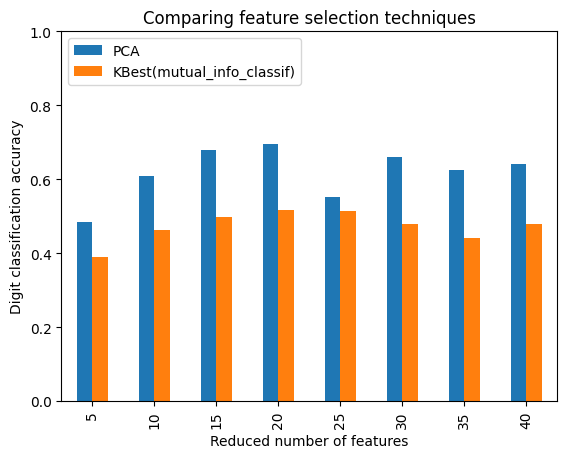

In [17]:
pipe = Pipeline([
    ('scaling', StandardScaler()),
    ('reduce_dim', 'passthrough'),
    ('classify', SVC(kernel='sigmoid', max_iter=1000))
])

N_FEATURES_OPTIONS = [5, 10, 15, 20, 25, 30, 35, 40]
C_OPTIONS = [10]
param_grid = [
    {
        'reduce_dim': [PCA()],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'classify__C': C_OPTIONS
    },
    {
        'reduce_dim': [SelectKBest(mutual_info_classif)],
        'reduce_dim__k': N_FEATURES_OPTIONS,
        'classify__C': C_OPTIONS
    },
]
reducer_labels = ['PCA', 'KBest(mutual_info_classif)']

grid = GridSearchCV(pipe, n_jobs=1, param_grid=param_grid)
grid.fit(X_train, y_train)

mean_scores = np.array(grid.cv_results_['mean_test_score'])
# scores are in the order of param_grid iteration, which is alphabetical
mean_scores = mean_scores.reshape(len(C_OPTIONS), -1, len(N_FEATURES_OPTIONS))
# select score for best C
mean_scores = mean_scores.max(axis=0)
mean_scores = pd.DataFrame(
    mean_scores.T, index=N_FEATURES_OPTIONS, columns=reducer_labels
)

ax = mean_scores.plot.bar()
ax.set_title("Comparing feature selection techniques")
ax.set_xlabel("Reduced number of features")
ax.set_ylabel("Digit classification accuracy")
ax.set_ylim((0, 1))
ax.legend(loc="upper left")

plt.show()